In [1]:
# Import libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

plt.style.use('ggplot')
pd.set_option('display.max_columns', False)
seed= 92

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Going to try the XGBoost model. Will start by tuningthe hyperparameters

Exploratory Data Analysis

In [4]:
#Combining train and test
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

#Duplicates and shapes
print(F"Number of duplicate rows: {len(all_data.drop('Survived', axis=1))-len(all_data.drop('Survived', axis=1).drop_duplicates())}")
print(f"Shape of train:    {train_data.shape}")
print(f"Shape of test:     {test_data.shape}")
print(f"Shape of all_data: {all_data.shape}")



Number of duplicate rows: 0
Shape of train:    (891, 12)
Shape of test:     (418, 11)
Shape of all_data: (1309, 12)


.info() provides usefull information including names of columns and datatypes:

In [5]:
print('#TRAIN INFO:')
print(train_data.info(),'\n')
print('#TEST INFO:')
print(test_data.info())

#TRAIN INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None 

#TEST INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 n

Check for duplicates in PassengerID column

In [6]:
print(F"Number of duplicates in PassengerId column = {len(all_data)-len(pd.unique(all_data['PassengerId']))}")

Number of duplicates in PassengerId column = 0


Survived

Value count
Survived
0    549
1    342
Name: count, dtype: int64

Ratio
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


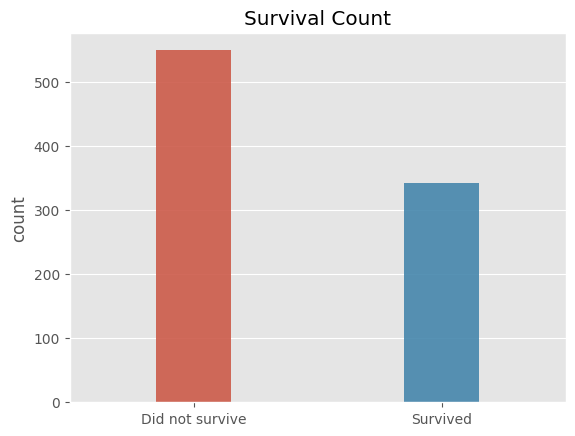

In [7]:
print("Value count")
print(train_data['Survived'].value_counts())
print("\nRatio")
print(train_data['Survived'].value_counts(normalize= True))

sns.countplot(data=train_data, x='Survived', width= 0.3, alpha= 0.9)
plt.xticks(ticks=[0, 1], labels=['Did not survive', 'Survived'])
plt.title("Survival Count")
plt.xlabel("")
plt.show()

Refers to Passenger class with a datatype of int64, where 1 represents 1st class, 2 represents 2nd class, and 3 represents 3rd class. It is notable that the survival percentage in the 1st class is the highest.

In [8]:
pclass_pivot = train_data.pivot_table(index='Pclass', columns='Survived', values='PassengerId', aggfunc='count')
pclass_pivot.columns = ['No', 'Yes']
pclass_pivot['Total'] = pclass_pivot['Yes'] + pclass_pivot['No']
pclass_pivot['Survival %'] = round(pclass_pivot['Yes'] / (pclass_pivot['Yes'] + pclass_pivot['No']) * 100,1).astype(str) + '%'
pclass_pivot

,No,Yes,Total,Survival %
Pclass,,,,
1,80,136,216,63.0%
2,97,87,184,47.3%
3,372,119,491,24.2%


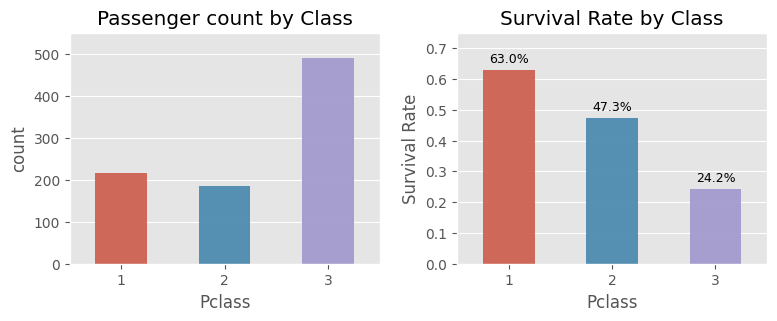

In [9]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Pclass", data=train_data, width= 0.5, alpha= 0.9, ax=ax1)
ax1.set_title("Passenger count by Class")
ax1.set_ylim([0, 550])


ax2= plt.subplot(1,2,2)
pclass_survival_rate = train_data.groupby('Pclass')['Survived'].mean().reset_index()
sns.barplot(x='Pclass', y='Survived', data=pclass_survival_rate,  alpha= 0.9, width= 0.5, ax= ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_xlabel('Pclass')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.75])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

This column includes the names of the passengers and their titles. The datatype is object. Upon inspection, there are two duplicate names in the dataset, you can see below that the duplicates have different ages and tickets, so we will assume that they are different people who happen to have the same name by chance.

In [10]:
print(F"Number of duplicates in Name column = {len(all_data)-len(pd.unique(all_data['Name']))}")

Number of duplicates in Name column = 2


In [11]:
all_data[all_data.duplicated(subset='Name', keep=False)].sort_values('Name')

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q
897,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S
891,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


This column indicates the sex of the passenger, with a datatype of object and values of either male or female. In our training data, we have 577 males and 314 females. Notably, being a female is good predictive of survival as 74.2% of women survived while only 18.9% of men survived.

In [12]:
sex_pivot = train_data.pivot_table(index='Sex', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
sex_pivot.columns = ['No', 'Yes']
sex_pivot['Total'] = sex_pivot.sum(axis=1)
sex_pivot['Survival %'] = round(sex_pivot['Yes'] / sex_pivot['Total']  * 100,1).astype(str) + '%'
sex_pivot

,No,Yes,Total,Survival %
Sex,,,,
female,81,233,314,74.2%
male,468,109,577,18.9%


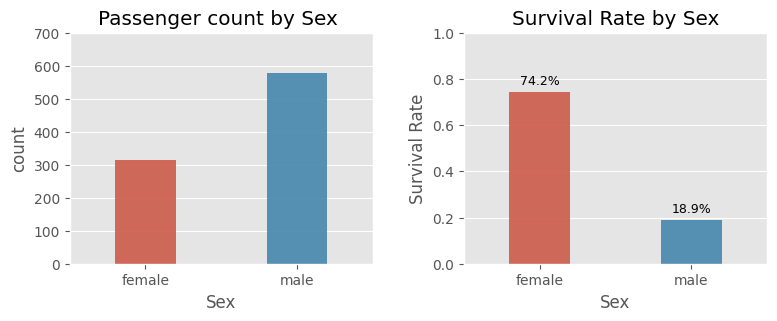

In [13]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Sex", data=train_data, width= 0.4, alpha= 0.9, order=['female', 'male'], ax=ax1)
ax1.set_title("Passenger count by Sex ")
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
sex_survival_rate = train_data.groupby('Sex')['Survived'].mean().reset_index()
sns.barplot(x='Sex', y='Survived', data=sex_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by Sex')
ax2.set_xlabel('Sex')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 1])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.3)
plt.show()

**Age**
Passenger age, datatype float64. Let's examine the age distribution in both the train and test datasets. The two histogrom plots in the first line below indicate that the distribution of age in both train and test datasets is comparable, and the kernal density plot (kde) below confirm that. However, when we look at the boxplot of age by survival status, we can see that the age distributions for both the "survived" and "did not survive" groups appear similar. This suggests that age, on it's own, may not be a strong predictor for survival.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


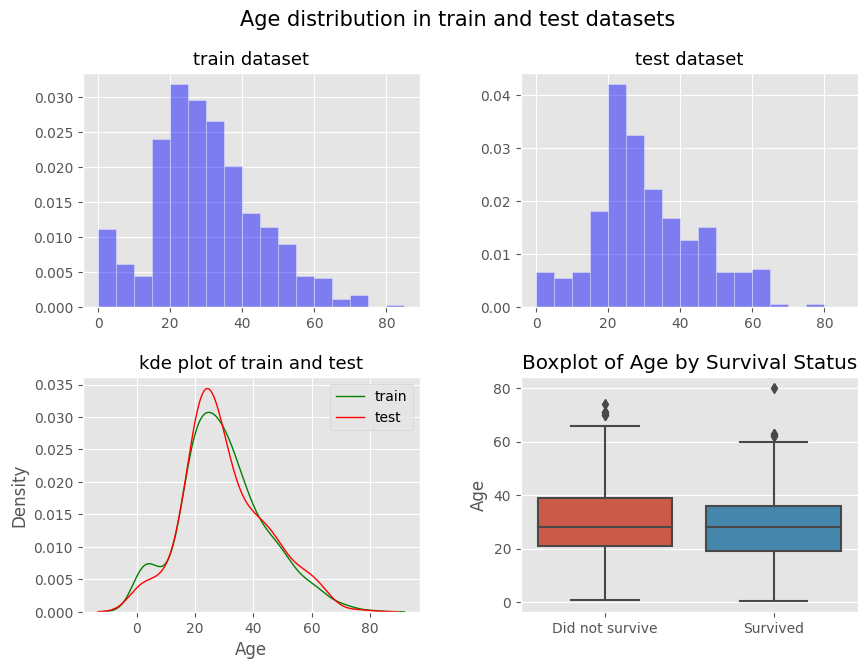

In [14]:
fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train_data['Age'].dropna(), bins=range(0, 90, 5))
ax1.hist(train_data['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test_data['Age'].dropna(), bins=range(0, 90, 5))
ax2.hist(test_data['Age'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train_data, x='Age', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test_data, x='Age', color='red', label='test', linewidth= 1, ax=ax3)
plt.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train_data.dropna(subset=['Age']), y="Age", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Age by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.suptitle('Age distribution in train and test datasets', y=0.97, fontsize=15)

plt.show()

**SibSp**
Represents the number of siblings and spouses a passenger had aboard. Its datatype is int64. We can see in the plot below that the majority of passengers didn't have siblings or spouses aboard, and those who had one or two SibSp have the highest survival rate, we also can see that none of the passengers with 5 or 6 SibSp survived.

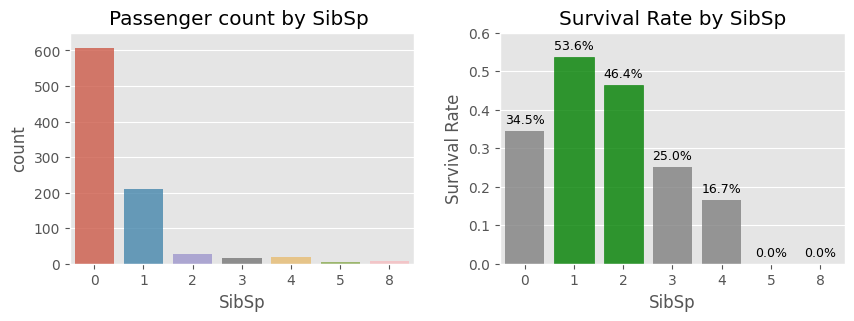

In [15]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="SibSp", data=train_data, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by SibSp ")
ax1.set_ylim([0, 650])

ax2= plt.subplot(1,2,2)
sibsp_survival_rate = train_data.groupby('SibSp')['Survived'].mean().reset_index()
sns.barplot(x='SibSp', y='Survived', data=sibsp_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,3):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by SibSp')
ax2.set_xlabel('SibSp')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.6])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

Here are the detailed counts for each category in the SibSp column:

In [16]:
SibSp_pivot= train_data.pivot_table(index= 'SibSp', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
SibSp_pivot.columns= ['No','Yes']
SibSp_pivot['Total'] = SibSp_pivot.sum(axis=1)
SibSp_pivot['Survival %']= round(SibSp_pivot['Yes']/SibSp_pivot['Total']*100,1).astype(str) + '%'
SibSp_pivot

,No,Yes,Total,Survival %
SibSp,,,,
0,398,210,608,34.5%
1,97,112,209,53.6%
2,15,13,28,46.4%
3,12,4,16,25.0%
4,15,3,18,16.7%
5,5,0,5,0.0%
8,7,0,7,0.0%


**Parch**
Refers to the number of parents and/or children aboard. It is an int64 data type. We see below that the majority of passengers did not have parents or children aboard, and people with 2,3 and 4 Parch has the highest survival rate.

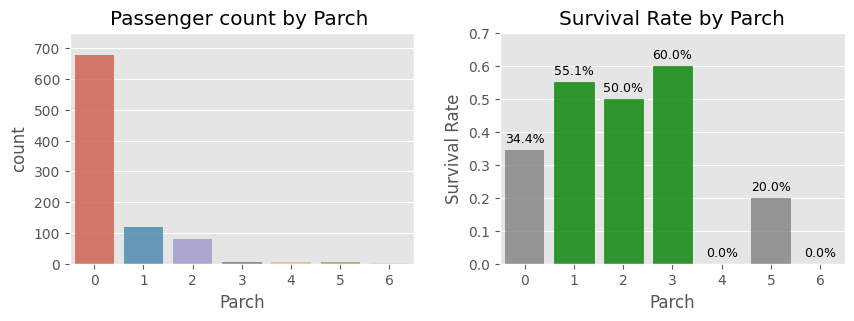

In [17]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Parch", data=train_data, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Parch ")
ax1.set_ylim([0, 750])

ax2= plt.subplot(1,2,2)
Parch_survival_rate = train_data.groupby('Parch')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Parch', y='Survived', data=Parch_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Parch')
ax2.set_xlabel('Parch')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.7])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

Here are the detailed counts for each category in the Parch column:

In [18]:
parch_pivot= train_data.pivot_table(index= 'Parch', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
parch_pivot.columns= ['No','Yes']
parch_pivot['Total'] = parch_pivot.sum(axis=1)
parch_pivot['Survival %']= round(parch_pivot['Yes']/parch_pivot['Total']*100,1).astype(str) +'%'
parch_pivot

,No,Yes,Total,Survival %
Parch,,,,
0,445,233,678,34.4%
1,53,65,118,55.1%
2,40,40,80,50.0%
3,2,3,5,60.0%
4,4,0,4,0.0%
5,4,1,5,20.0%
6,1,0,1,0.0%


**Ticket**
Ticket number, datatype object. We notice below that a ticket number might belong to more than one passenger and some of the tickets has a string prefix

In [19]:
train_data['Ticket'].value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

**Fare**
Passenger Fare (British pound), datatype float64. As we saw before with the age variable, the ditribution of fare between train and test datasets is comparable. However,the boxplot shows that the majority of passengers who didn't survive paid less than the median fare paid by passengers who suvived . we also see that the fare varies, as there are 248 unique fare amounts paid.
Note: in the boxplot, I eleminated the one passenger who paid more than 500 as this outlier was causing the whole plot to be more compressed, you can undo that by deleting the condition "[train['Fare']<500]"

In [20]:
print(F"Number of unique Fare values= {len(pd.unique(train_data['Fare']))}")

Number of unique Fare values= 248


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


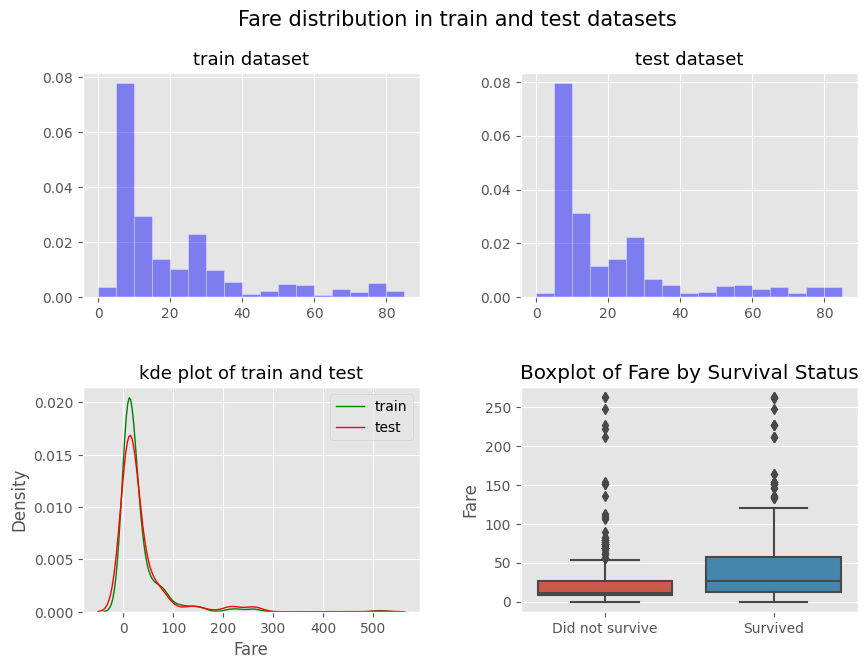

In [21]:
fig = plt.figure(figsize=(10, 7))

ax1 = plt.subplot(2, 2, 1)
count, bin_edges = np.histogram(train_data['Fare'], bins=range(0, 90, 5))
ax1.hist(train_data['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax1.set_title('train dataset', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
count, bin_edges = np.histogram(test_data['Fare'], bins=range(0, 90, 5))
ax2.hist(test_data['Fare'].dropna(), bins=bin_edges, alpha= 0.45, density=True, color='blue', edgecolor='white')
ax2.set_title('test dataset', fontsize=13)

ax3 = plt.subplot(2, 2, 3)
sns.kdeplot(data=train_data, x='Fare', color='green', label='train', linewidth= 1, ax=ax3)
sns.kdeplot(data=test_data, x='Fare', color='red', label='test', linewidth= 1, ax=ax3)
ax3.legend()
ax3.set_title('kde plot of train and test', fontsize=13)

ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=train_data[train_data['Fare']<500], y="Fare", x="Survived", ax=ax4)
ax4.set_xticks([0, 1], ['Did not survive', 'Survived'])
ax4.set_title("Boxplot of Fare by Survival Status")
ax4.set_xlabel("")

plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.suptitle('Fare distribution in train and test datasets', y=0.97, fontsize=15)
plt.show()

**Cabin**
The Cabin column contains a combination of letters and numbers that correspond to a passenger's assigned cabin. We can observe from the data that some passengers were assigned multiple cabins, and when this occurs, all the cabins share the same letter. Based on this observation, we can group passengers by the letter in their cabin code

In [22]:
train_data['Cabin'].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

# Embarked
The "Embarked" column represents the port of embarkation and has a datatype of object. The values are "C" for Cherbourg, "Q" for Queenstown, and "S" for Southampton. We can see below that the majority of passengers who did not survive embarked in Southampton.

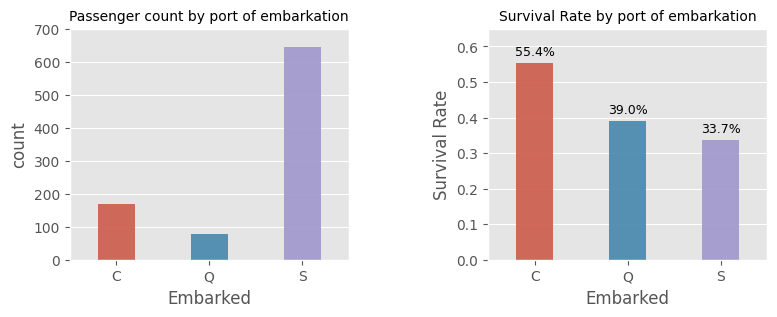

In [23]:
fig= plt.figure(figsize=(9,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Embarked", data=train_data, width= 0.4, alpha= 0.9, order=['C', 'Q', 'S'], ax=ax1)
ax1.set_title("Passenger count by port of embarkation", fontsize=10)
ax1.set_ylim([0, 700])


ax2= plt.subplot(1,2,2)
Embarked_survival_rate = train_data.groupby('Embarked')['Survived'].mean().reset_index()
sns.barplot(x='Embarked', y='Survived', data=Embarked_survival_rate,  alpha= 0.9, width= 0.4, ax= ax2)
ax2.set_title('Survival Rate by port of embarkation', fontsize=10)
ax2.set_xlabel('Embarked')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.65])
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.5)
plt.show()

Here are the detailed counts for each category in the Embarked column:


In [24]:
embarked_pivot = train_data.pivot_table(index='Embarked', columns='Survived', values='PassengerId', aggfunc='count', fill_value= 0)
embarked_pivot.columns = ['No', 'Yes']
embarked_pivot['Total'] = embarked_pivot.sum(axis=1)
embarked_pivot['Survival %'] = round(embarked_pivot['Yes'] / embarked_pivot['Total']  * 100,1).astype(str) + '%'
embarked_pivot

,No,Yes,Total,Survival %
Embarked,,,,
C,75,93,168,55.4%
Q,47,30,77,39.0%
S,427,217,644,33.7%


# Correlation
From the correlation matrix, we see that:
    Survived is noticabily correlated with Pclass and Fare
    Pclass is noticabily correlated with Age and Fare.
    Age is noticabily correlated with Pclass, SibSp and Parch.
    SibSP is noticabily correlated with Parch and Fare.
    Parch is noticabily correlated with Fare.
    Survived is noticabily correlated with Pclass and Fare
    Pclass is noticabily correlated with Age and Fare.
    Age is noticabily correlated with Pclass, SibSp and Parch.
    SibSP is noticabily correlated with Parch and Fare.
    Parch is noticabily correlated with Fare.

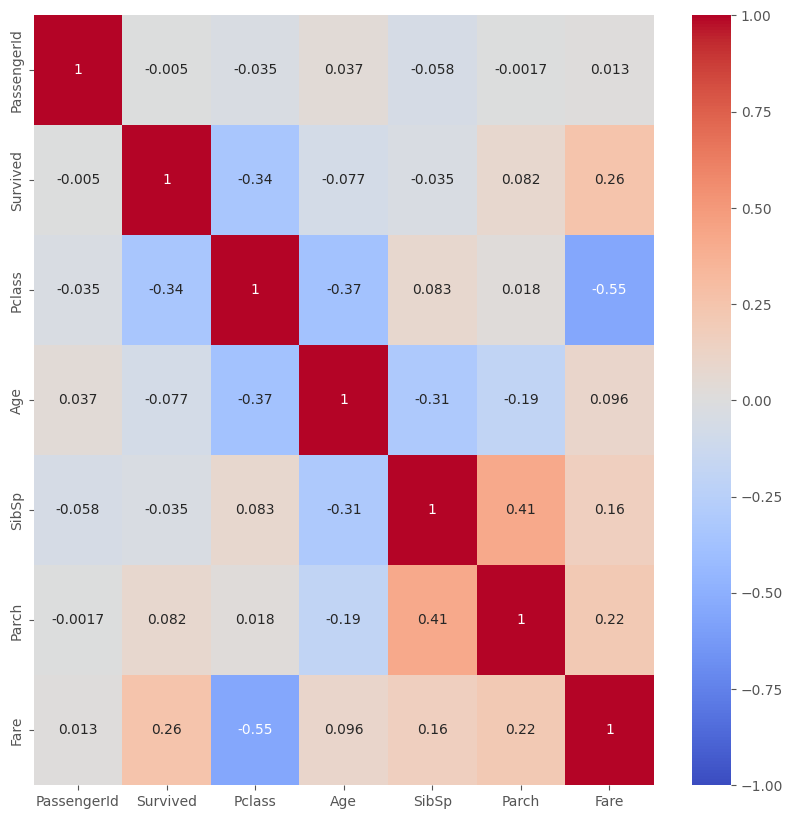

In [25]:
df=train_data.drop(['Name','Sex','Ticket','Cabin','Embarked'],axis=1)
corr= df.corr()
plt.figure(figsize= (10,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Data Wrangling
Age, cabin and embarked can all be seen to have missing values

In [26]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Age**
It can be seen from the below plots the age distribution varies with Pclass and gender

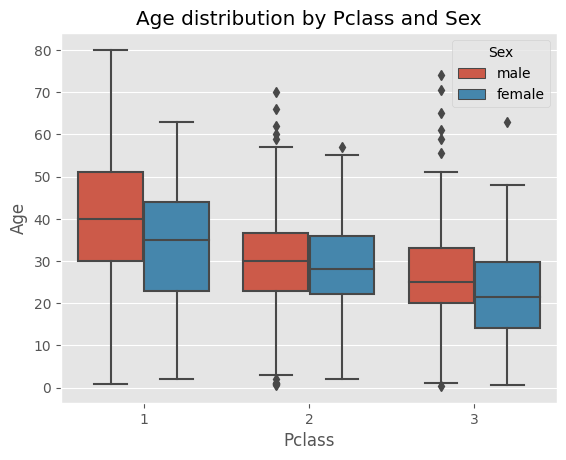

In [27]:
sns.boxplot(x='Pclass', y='Age', hue='Sex', data=train_data)
plt.title('Age distribution by Pclass and Sex')
plt.show()

So let's account for this by getting medians by age and Pclass

In [28]:
age_median = train_data.groupby(['Pclass','Sex'])['Age'].median()
age_median

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

Apply this to the missing data

In [29]:
train_data['Age'] = train_data.apply(lambda x: age_median.loc[(x['Pclass'], x['Sex'])] if np.isnan(x['Age']) else x['Age'], axis=1)

Verify that we now how no missing values in Age column and that we've not introduced any errors (i.e. skewed the median values by Pclass and gender)

In [30]:
train_data['Age'].isnull().sum()
age_median = train_data.groupby(['Pclass','Sex'])['Age'].median()
age_median

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

# Missing Values in the Embarked Column
Only two missing values, will replace with the modal value for embarked. NB, the author had a good idea of search for the same ticket number to see if anyone else on the same ticket had the embarkation port marked. No dice though.

In [31]:
most_frequent_value= train_data['Embarked'].value_counts().idxmax()
train_data['Embarked'].replace(np.nan, most_frequent_value, inplace=True)
print(F"Most frequent value= {most_frequent_value}")

Most frequent value= S


/tmp/ipykernel_13/2859541619.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Embarked'].replace(np.nan, most_frequent_value, inplace=True)


# Missing Values in the Cabin Column
Each cabin is identified by a letter and a number, some passengers are assigned more than one cabin but with the same letter. Therefore, we can drop the number keeping only the cabin letter. We will carry on imputing missing values in cabin in the feature engineering section below

In [32]:
list(train_data["Cabin"].unique())

[nan,
 'C85',
 'C123',
 'E46',
 'G6',
 'C103',
 'D56',
 'A6',
 'C23 C25 C27',
 'B78',
 'D33',
 'B30',
 'C52',
 'B28',
 'C83',
 'F33',
 'F G73',
 'E31',
 'A5',
 'D10 D12',
 'D26',
 'C110',
 'B58 B60',
 'E101',
 'F E69',
 'D47',
 'B86',
 'F2',
 'C2',
 'E33',
 'B19',
 'A7',
 'C49',
 'F4',
 'A32',
 'B4',
 'B80',
 'A31',
 'D36',
 'D15',
 'C93',
 'C78',
 'D35',
 'C87',
 'B77',
 'E67',
 'B94',
 'C125',
 'C99',
 'C118',
 'D7',
 'A19',
 'B49',
 'D',
 'C22 C26',
 'C106',
 'C65',
 'E36',
 'C54',
 'B57 B59 B63 B66',
 'C7',
 'E34',
 'C32',
 'B18',
 'C124',
 'C91',
 'E40',
 'T',
 'C128',
 'D37',
 'B35',
 'E50',
 'C82',
 'B96 B98',
 'E10',
 'E44',
 'A34',
 'C104',
 'C111',
 'C92',
 'E38',
 'D21',
 'E12',
 'E63',
 'A14',
 'B37',
 'C30',
 'D20',
 'B79',
 'E25',
 'D46',
 'B73',
 'C95',
 'B38',
 'B39',
 'B22',
 'C86',
 'C70',
 'A16',
 'C101',
 'C68',
 'A10',
 'E68',
 'B41',
 'A20',
 'D19',
 'D50',
 'D9',
 'A23',
 'B50',
 'A26',
 'D48',
 'E58',
 'C126',
 'B71',
 'B51 B53 B55',
 'D49',
 'B5',
 'B20',
 'F G

# Feature Engineering
**Cabin_Letter**

We will start by creating a new feature named Cabin_Letter by extracting the first letter in cabin and replacing empty values with Unknown then we drop the Cabin column:

In [33]:
train_data['Cabin_Letter'] = train_data['Cabin'].str[:1]
train_data.Cabin_Letter.fillna('Unknown', inplace=True)
train_data= train_data.drop(columns=['Cabin'])
train_data.Cabin_Letter.value_counts()

/tmp/ipykernel_13/4283595274.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data.Cabin_Letter.fillna('Unknown', inplace=True)


Cabin_Letter
Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: count, dtype: int64

Look to see if there's any pattern to be seen between cabin letter and survival chances

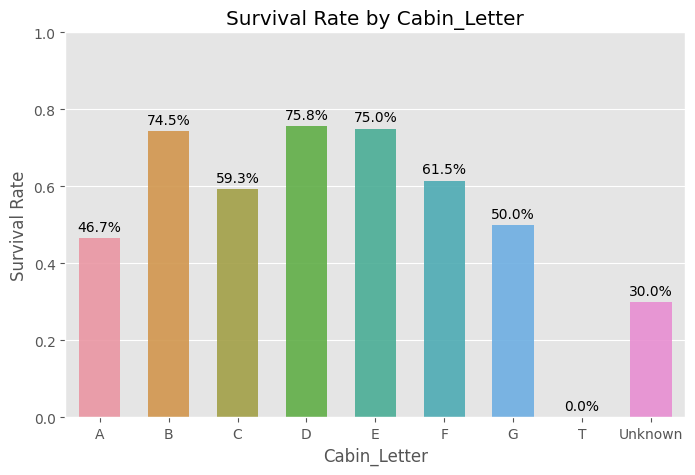

In [34]:
fig= plt.figure(figsize=(8,5))

Cabin_Letter_survival_rate = train_data.groupby('Cabin_Letter')['Survived'].mean().reset_index()
ax= sns.barplot(x='Cabin_Letter', y='Survived', data=Cabin_Letter_survival_rate,  alpha= 0.9, width= 0.6)
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 8),
                textcoords='offset points')
plt.title('Survival Rate by Cabin_Letter', )
plt.xlabel('Cabin_Letter')
plt.ylabel('Survival Rate')
plt.ylim([0, 1])

plt.show()

We already know (from another tutorial), that gender makes a difference. 
Let's create a binary column Is_Female to represent female passengers in the data. This avoids redundant one-hot encoding for male and female, and can be used as a binary feature in analysis and our machine learning models. The original 'Sex' column is retained for potential future use.

In [35]:
train_data['Is_Female']= train_data.Sex.apply(lambda x: 1 if x=='female' else 0)

# Family_Size
The summation of Parch and SibSp plus 1

In [36]:
train_data['Family_Size']= train_data['Parch'] + train_data['SibSp'] + 1

Plotting the Family_Size feature reveals that the majority of passengers are traveling without family members. Additionally, families consisting of 2, 3, and 4 members exhibit the highest survival rates, while families with more than 7 members have a 0% survival rate. This information suggests that family size could be a relevant factor in predicting survival chances

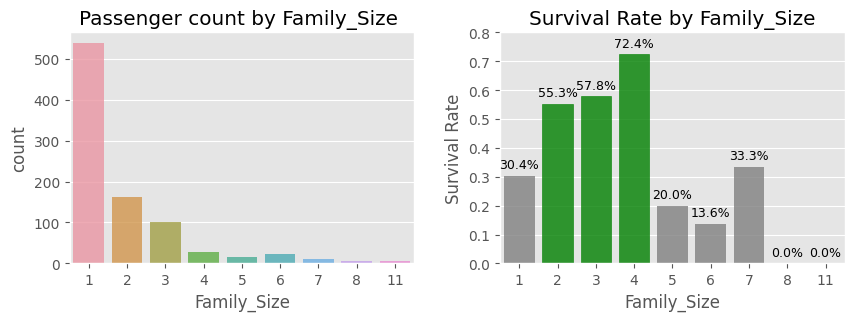

In [37]:
fig= plt.figure(figsize=(10,3))

ax1= plt.subplot(1,2,1)
sns.countplot(x="Family_Size", data=train_data, alpha= 0.8, ax=ax1)
ax1.set_title("Passenger count by Family_Size ")

ax2= plt.subplot(1,2,2)
Family_Size_survival_rate = train_data.groupby('Family_Size')['Survived'].mean().reset_index().sort_values(by='Survived', ascending=False)
sns.barplot(x='Family_Size', y='Survived', data=Family_Size_survival_rate, alpha= 0.8, color='grey', ax= ax2)
for i in range(1,4):
    plt.gca().get_children()[i].set_color('g')
ax2.set_title('Survival Rate by Family_Size')
ax2.set_xlabel('Family_Size')
ax2.set_ylabel('Survival Rate')
ax2.set_ylim([0, 0.8])

for p in ax2.patches:
    ax2.annotate(f'{p.get_height()*100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                textcoords='offset points')

plt.subplots_adjust(wspace=0.25)
plt.show()

As a side note...given the times, I'm wondering if the vast majority of solo travellers were male.
Will have a go at finding out...and yes, 411 of the approx 550 solo travellers are blokes.


In [38]:
#train_data['Is_Female'].value_counts()
count = ((train_data['Family_Size']==1)&(train_data['Is_Female']==0)).sum()


Let's now group the family size values into four categories, namely 'Alone' for family size 1, 'Small' for family size 2, 3, or 4, 'Medium' for family size 5 or 6, and 'Large' for family size 7, 8, or 11. This grouping helps in categorizing passengers based on their family size

In [39]:
train_data['Family_Size']=train_data['Family_Size'].map({1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', \
                                                         8: 'Large', 11: 'Large'})
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Letter,Is_Female,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Unknown,0,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Small
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Unknown,1,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,C,1,Small
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Unknown,0,Alone


# Group_Size
Group_Size is the number of passengers with the same ticket, we fill this column up with the frequency of the passenger's ticket after calculating ticket frequency in all data:

In [40]:
tickets= all_data.groupby(['Ticket'])[['PassengerId']].count().rename(columns={'PassengerId': 'Count'})
tickets.head()

,Count
Ticket,
110152,3
110413,3
110465,2
110469,1
110489,1


In [41]:
train_data['Group_Size']=train_data['Ticket'].apply(lambda x: tickets.loc[x, 'Count'])

# Title
We will extract the titles from the name field and make a new feature Title, which would help us capture information about the social status of passengers

In [42]:
train_data['Title'] = train_data['Name'].str.split(', ').str[1].str.split('.').str[0]

Extracting all titles from train and test:

In [43]:
all_data['Title'] = all_data['Name'].str.split(', ').str[1].str.split('.').str[0]
all_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

let's group some of the titles together:

In [44]:
title_mapping= {'Mr':'Mr', 'Mrs':'Mrs', 'Miss':'Miss','Master':'Master', 'Don':'Rare', 'Rev':'Rare', 'Dr':'Rare', 'Mme':'Mrs', 'Ms':'Miss',
       'Major':'Rare', 'Lady':'Rare' , 'Sir':'Rare', 'Mlle':'Miss', 'Col':'Rare', 'Capt':'Rare', 'the Countess':'Rare',
       'Jonkheer':'Rare', 'Dona':'Rare'}
train_data['Title']= train_data['Title'].map(title_mapping)

In [45]:
train_data['Title'].value_counts()

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

# Fare_bin
Let's look again at the destribution of data in Fare column using a box plot.
Note that I showed two boxplots of the Fare column, the only difference is that I eliminated one outlier (>500) in the plot on the right to show a less compressed plot.

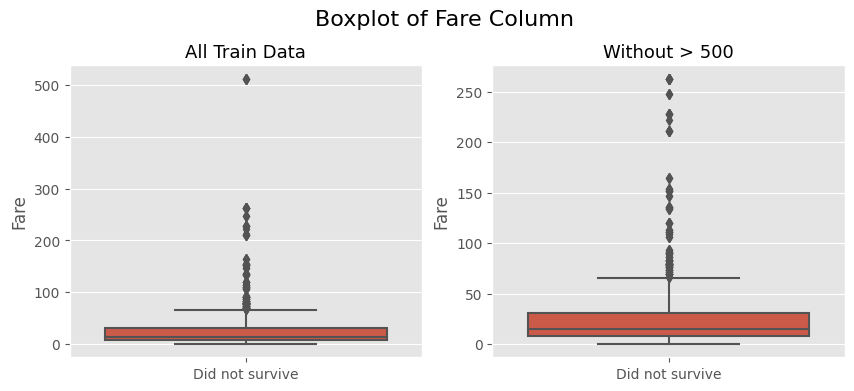

In [46]:
fig = plt.figure(figsize=(10, 4))

ax1 = plt.subplot(1, 2, 1)
sns.boxplot(data=train_data, y="Fare", ax=ax1)
ax1.set_xticks([0], ['Did not survive'])
ax1.set_title("All Train Data", fontsize= 13)

ax2 = plt.subplot(1, 2, 2)
sns.boxplot(data=train_data[train_data['Fare']<500], y="Fare",  ax=ax2)
ax2.set_xticks([0], ['Did not survive'])
ax2.set_title("Without > 500", fontsize= 13)

plt.suptitle('Boxplot of Fare Column', fontsize= 16)
plt.subplots_adjust(top=0.84)

plt.show()

We will bin the 'Fare' column by calculating the quartiles and defining bin edges based on them. This will create 5 bins:

In [47]:
Q1, Q2, Q3 = np.percentile(train_data['Fare'], [25, 50, 75])
IQR = Q3 - Q1

fare_bin_edges = [-np.inf, Q1, Q2, Q3, 1.5 * IQR, np.inf]

fare_bin_labels=[]
for i in range(len(fare_bin_edges)-1):
    fare_bin_labels.append("{}_to_{}".format(fare_bin_edges[i], fare_bin_edges[i+1]))

train_data['Fare_bin'] = pd.cut(train_data['Fare'], bins=fare_bin_edges, labels=fare_bin_labels)

Number of passenger in each Fare_bin:

In [48]:
train_data[['Fare_bin']].value_counts()

Fare_bin         
7.9104_to_14.4542    224
-inf_to_7.9104       223
14.4542_to_31.0      222
34.6344_to_inf       200
31.0_to_34.6344       22
Name: count, dtype: int64

Passenger in the highest fare bin have the highest survival rate while those in the lowest fare bin have the lowest survival rate:

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


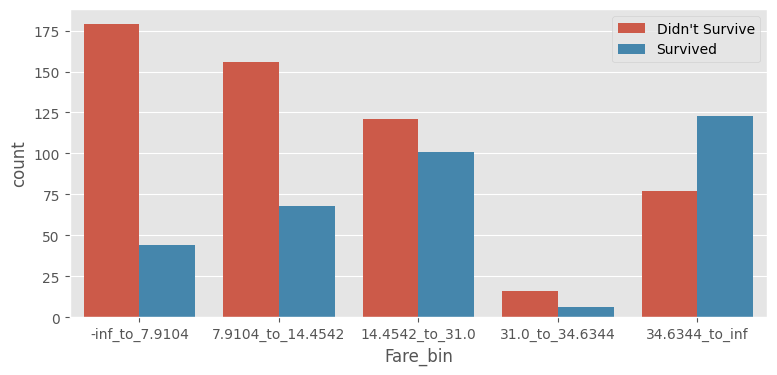

In [49]:
plt.figure(figsize=(9,4))
sns.countplot(x='Fare_bin', hue='Survived', data=train_data)
plt.legend(labels=["Didn't Survive","Survived"])
plt.show()

# Age_bin
Let's also make bins for Age, I will divivde Age into 10 bins, from 0 to 80 years old

In [50]:
Q1 = train_data['Age'].quantile(0.25)
Q3 = train_data['Age'].quantile(0.75)
IQR = Q3 - Q1

num_bins = 10
age_bin_edges = np.linspace(start=0, stop=train_data.Age.max(), num=num_bins + 1).astype(int)

age_bin_labels=[]
for i in range(len(age_bin_edges)-1):
    age_bin_labels.append("{}_to_{}".format(age_bin_edges[i], age_bin_edges[i+1]))

train_data['Age_bin'] = pd.cut(train_data['Age'], bins=age_bin_edges, labels= age_bin_labels)

Below we can see from the value count that we probably can benefit from looking into further dividing the three bins with the highest number of passengers. I will keep them as they are for now:

In [51]:
train_data['Age_bin'].value_counts()

Age_bin
24_to_32    274
16_to_24    219
32_to_40    148
40_to_48     70
0_to_8       54
8_to_16      46
48_to_56     45
56_to_64     24
64_to_72      9
72_to_80      2
Name: count, dtype: int64

When we plot the age bins, we notice that the only bin with more surviving passengers than perishing ones is the bin that includes passengers aged 0 to 8 years.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


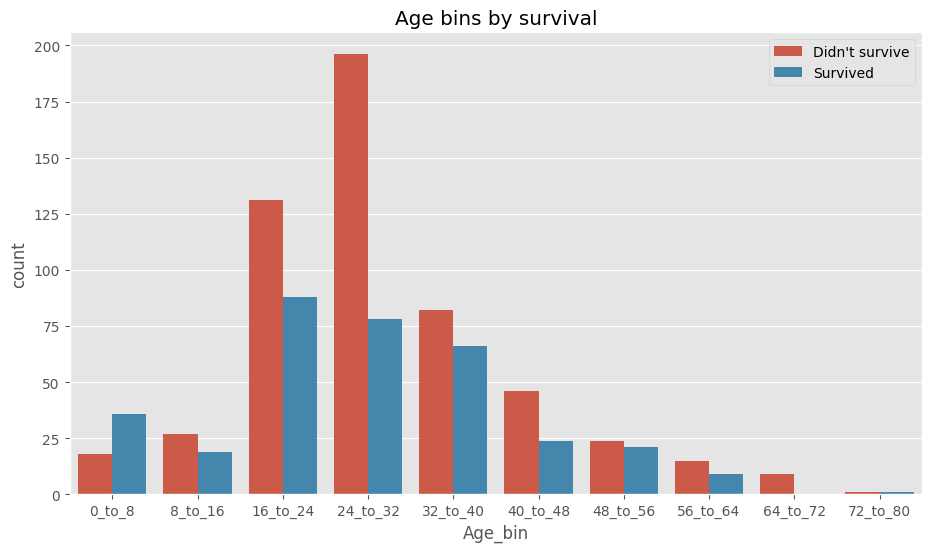

In [52]:
plt.figure(figsize=(11,6))
sns.countplot(x='Age_bin', hue='Survived', data=train_data)
plt.legend(["Didn't survive","Survived"])
plt.title('Age bins by survival')
plt.show()

# Feature Interaction
Now we will creat multiple features using the interactions between the features we have:

In [53]:
train_data["Age_bin_Sex"] = train_data["Age_bin"].astype(str) + "_" + train_data["Sex"]
train_data["Age_bin_Pclass"] = train_data["Age_bin"].astype(str) + "_" + train_data["Pclass"].astype(str)

train_data["Fare_bin_Sex"] = train_data["Fare_bin"].astype(str) + "_" + train_data["Sex"]
train_data["Fare_bin_Pclass"] = train_data["Fare_bin"].astype(str) + "_" + train_data["Pclass"].astype(str)

train_data["Pclass_Sex"] = train_data["Pclass"].astype(str) + "_" + train_data["Sex"]
train_data["Pclass_Title"] = train_data["Pclass"].astype(str) + "_" + train_data["Title"]
train_data["Sex_Title"] = train_data["Sex"].astype(str) + "_" + train_data["Title"]

train_data["Age_bin_Title"] = train_data["Age_bin"].astype(str) + "_" + train_data["Title"]
train_data["Fare_bin_Title"] = train_data["Fare_bin"].astype(str) + "_" + train_data["Title"]

train_data['Fam_Size_Cabin']= train_data["Family_Size"].astype(str) + "_" + train_data["Cabin_Letter"].astype(str)
train_data['Fam_Size_Parch']= train_data["Family_Size"].astype(str) + "_" + train_data["Parch"].astype(str)
train_data['Fam_Size_Fare_bin']= train_data["Family_Size"].astype(str) + "_" + train_data["Fare_bin"].astype(str)

train_data['SibSp_Parch_Ratio'] = train_data.apply(lambda x: x['SibSp'] / train_data.loc[x.name, 'Parch'] if train_data.loc[x.name, 'Parch'] != 0 else 0, axis=1)
train_data['Age_bin_Fare_bin']= train_data["Age_bin"].astype(str) + "_" + train_data["Fare_bin"].astype(str)

# Applying same changes to the test dataset

Missing values:

In [54]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Filling missing values in Age column (remembering that we created a look up for median age based on gender and Pclass earlier and saved it as age_median:

In [55]:
test_data['Age']= test_data.apply(lambda x: age_median.loc[(x['Pclass'], x['Sex'])] if np.isnan(x['Age']) else x['Age'], axis=1)

Let's take a look at the row with the missing value in the Fare column:

In [56]:
test_data[test_data.isnull()['Fare']==True]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Since the passenger above isn't traveling with any family number, we can't find the exact fare for him, so let's replace the fare value with the mean of the Fare column.

In [57]:
avg_fare = test_data['Fare'].mean()
test_data['Fare'].replace(np.nan, avg_fare, inplace=True)

/tmp/ipykernel_13/1019816923.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Fare'].replace(np.nan, avg_fare, inplace=True)


We need to structure the new features we created in the feature engineering process, ideally, we would do that using a function or a pipeline, but since this process is for learning, I will do it step by step:

In [58]:
#Cabin_Letter
test_data['Cabin_Letter'] = test_data['Cabin'].str[:1]
test_data.Cabin_Letter= test_data.Cabin_Letter.fillna('Unknown')

#Family_Size
test_data['Family_Size']= test_data['Parch'] + test_data['SibSp'] + 1
test_data['Family_Size']=test_data['Family_Size'].map({1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'})

#Is_Female
test_data['Is_Female']= test_data.Sex.apply(lambda x: 1 if x=='female' else 0)

#Group_Size
test_data['Group_Size']=test_data['Ticket'].apply(lambda x: tickets.loc[x, 'Count'])

#Title
test_data['Title'] = test_data['Name'].str.split(', ').str[1].str.split('.').str[0]
test_data['Title']= test_data['Title'].map(title_mapping)

#Fare_bin
test_data['Fare_bin'] = pd.cut(test_data['Fare'], bins=fare_bin_edges, labels=fare_bin_labels)

#Age_bins
test_data['Age_bin'] = pd.cut(test_data['Age'], bins=age_bin_edges, labels=age_bin_labels)

#SibSp_Parch Ratio
test_data['SibSp_Parch_Ratio'] = test_data.apply(lambda x: x['SibSp'] / test_data.loc[x.name, 'Parch'] if test_data.loc[x.name, 'Parch'] != 0 else 0, axis=1)

#Age_bin / Sex
test_data["Age_bin_Sex"] = test_data["Age_bin"].astype(str) + "_" + test_data["Sex"]

#Age_bin / Pcalss
test_data["Age_bin_Pclass"] = test_data["Age_bin"].astype(str) + "_" + test_data["Pclass"].astype(str)

#Fare_bin / Sex
test_data["Fare_bin_Sex"] = test_data["Fare_bin"].astype(str) + "_" + train_data["Sex"]

#Fare_bin / Pclass
test_data["Fare_bin_Pclass"] = test_data["Fare_bin"].astype(str) + "_" + test_data["Pclass"].astype(str)

#Pclass / Sex
test_data["Pclass_Sex"] = test_data["Pclass"].astype(str) + "_" + test_data["Sex"]

#Pclass / Title
test_data["Pclass_Title"] = test_data["Pclass"].astype(str) + "_" + test_data["Title"]

#Sex / Title
test_data["Sex_Title"] = test_data["Sex"].astype(str) + "_" + test_data["Title"]

#Age_bin / Title
test_data["Age_bin_Title"] = test_data["Age_bin"].astype(str) + "_" + test_data["Title"]

#Fare_bin / Title
test_data["Fare_bin_Title"] = test_data["Fare_bin"].astype(str) + "_" + test_data["Title"]

#Fam_Size / Cabin_Letter
test_data['Fam_Size_Cabin']= test_data["Family_Size"].astype(str) + "_" + test_data["Cabin_Letter"].astype(str)

#Fam_Size / Parch
test_data['Fam_Size_Parch']= test_data["Family_Size"].astype(str) + "_" + test_data["Parch"].astype(str)

#Fam_Size / Fare_bin
test_data['Fam_Size_Fare_bin']= test_data["Family_Size"].astype(str) + "_" + test_data["Fare_bin"].astype(str)


test_data.drop(columns=['Cabin'],inplace= True)

test_data['Age_bin_Fare_bin']= test_data["Age_bin"].astype(str) + "_" + test_data["Fare_bin"].astype(str)

# Dropping unnecessary columns

In [59]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Cabin_Letter', 'Is_Female',
       'Family_Size', 'Group_Size', 'Title', 'Fare_bin', 'Age_bin',
       'Age_bin_Sex', 'Age_bin_Pclass', 'Fare_bin_Sex', 'Fare_bin_Pclass',
       'Pclass_Sex', 'Pclass_Title', 'Sex_Title', 'Age_bin_Title',
       'Fare_bin_Title', 'Fam_Size_Cabin', 'Fam_Size_Parch',
       'Fam_Size_Fare_bin', 'SibSp_Parch_Ratio', 'Age_bin_Fare_bin'],
      dtype='object')

In [60]:
cols_to_drop=['Sex','Name','Ticket']
for df in [train_data,test_data]:
    df.drop(columns=cols_to_drop, inplace= True)

In [61]:
train_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Cabin_Letter,Is_Female,Family_Size,Group_Size,Title,Fare_bin,Age_bin,Age_bin_Sex,Age_bin_Pclass,Fare_bin_Sex,Fare_bin_Pclass,Pclass_Sex,Pclass_Title,Sex_Title,Age_bin_Title,Fare_bin_Title,Fam_Size_Cabin,Fam_Size_Parch,Fam_Size_Fare_bin,SibSp_Parch_Ratio,Age_bin_Fare_bin
0,1,0,3,22.0,1,0,7.2500,S,Unknown,0,Small,1,Mr,-inf_to_7.9104,16_to_24,16_to_24_male,16_to_24_3,-inf_to_7.9104_male,-inf_to_7.9104_3,3_male,3_Mr,male_Mr,16_to_24_Mr,-inf_to_7.9104_Mr,Small_Unknown,Small_0,Small_-inf_to_7.9104,0.0,16_to_24_-inf_to_7.9104
1,2,1,1,38.0,1,0,71.2833,C,C,1,Small,2,Mrs,34.6344_to_inf,32_to_40,32_to_40_female,32_to_40_1,34.6344_to_inf_female,34.6344_to_inf_1,1_female,1_Mrs,female_Mrs,32_to_40_Mrs,34.6344_to_inf_Mrs,Small_C,Small_0,Small_34.6344_to_inf,0.0,32_to_40_34.6344_to_inf
2,3,1,3,26.0,0,0,7.9250,S,Unknown,1,Alone,1,Miss,7.9104_to_14.4542,24_to_32,24_to_32_female,24_to_32_3,7.9104_to_14.4542_female,7.9104_to_14.4542_3,3_female,3_Miss,female_Miss,24_to_32_Miss,7.9104_to_14.4542_Miss,Alone_Unknown,Alone_0,Alone_7.9104_to_14.4542,0.0,24_to_32_7.9104_to_14.4542
3,4,1,1,35.0,1,0,53.1000,S,C,1,Small,2,Mrs,34.6344_to_inf,32_to_40,32_to_40_female,32_to_40_1,34.6344_to_inf_female,34.6344_to_inf_1,1_female,1_Mrs,female_Mrs,32_to_40_Mrs,34.6344_to_inf_Mrs,Small_C,Small_0,Small_34.6344_to_inf,0.0,32_to_40_34.6344_to_inf
4,5,0,3,35.0,0,0,8.0500,S,Unknown,0,Alone,1,Mr,7.9104_to_14.4542,32_to_40,32_to_40_male,32_to_40_3,7.9104_to_14.4542_male,7.9104_to_14.4542_3,3_male,3_Mr,male_Mr,32_to_40_Mr,7.9104_to_14.4542_Mr,Alone_Unknown,Alone_0,Alone_7.9104_to_14.4542,0.0,32_to_40_7.9104_to_14.4542


# One-Hot encoding categorical columns

In [62]:
cat_variables= ['Embarked',
                'Fam_Size_Cabin',
                'Fam_Size_Parch',
                'Fam_Size_Fare_bin' ,
                'Cabin_Letter',
                'Title',
                'Family_Size',
                'Age_bin_Sex',
                'Age_bin_Pclass',
                'Fare_bin_Sex',
                'Fare_bin_Pclass',
                'Fare_bin_Title',
                'Pclass_Sex',
                'Pclass_Title',
                'Sex_Title',
                'Age_bin_Title',
                'Fare_bin',
                'Age_bin',
                'Age_bin_Fare_bin']

In [63]:
train_data = pd.get_dummies(data = train_data,
                       prefix = cat_variables,
                       columns = cat_variables)

test_data = pd.get_dummies(data = test_data,
                       prefix = cat_variables,
                       columns = cat_variables)

In [64]:
print(F"Number of columns in train= {train_data.shape[1]}")
print(F"Number of columns in test= {test_data.shape[1]}")

Number of columns in train= 294
Number of columns in test= 274


Let's now align train and test columns so that we have the same columns in both of them:

In [65]:
train_data, test_data = train_data.align(test_data, axis=1, fill_value=0)
print(F"Number of columns in train= {train_data.shape[1]}")
print(F"Number of columns in test= {test_data.shape[1]}")

Number of columns in train= 300
Number of columns in test= 300


# Feature Selection
Most of the features generated through feature engineering are binary, indicating that the column is filled with 0 if the passenger does not belong to the group represented by the feature, and 1 if the passenger does belong to the group. By summing the binary columns, we can determine the number of passengers included in each feature. If a feature has a very small number of passengers, it may not be helpful, and keeping it could lead to overfitting, as our model would have to consider a characteristic that only applies to one or a few passenger. Therefore, let's select the binary features that include at least 10% of the passengers, and from those that include less than 10% of passengers we will only take those with a correlation >= 0.15 with the target 'Survived'
Note that we have to drop the target column 'Survived'.

In [66]:
corr_with_survived= train_data.corr()[['Survived']] 
selected_binary_features = [col for col in train_data.columns 
                            if set(train_data[col].unique()) == {0, 1} 
                                and (train_data[col].sum()/len(train_data) > 0.1 and  abs(corr_with_survived.loc[col].values[0])>= 0.15 )]



if 'Survived' in selected_binary_features:
    selected_binary_features.remove('Survived')
print(F"Number of selected binary features= {len(selected_binary_features)}")
selected_binary_features

Number of selected binary features= 38


['Age_bin_Fare_bin_24_to_32_-inf_to_7.9104',
 'Age_bin_Pclass_24_to_32_3',
 'Age_bin_Sex_16_to_24_female',
 'Age_bin_Sex_16_to_24_male',
 'Age_bin_Sex_24_to_32_male',
 'Age_bin_Title_16_to_24_Mr',
 'Age_bin_Title_24_to_32_Mr',
 'Cabin_Letter_Unknown',
 'Embarked_C',
 'Fam_Size_Cabin_Alone_Unknown',
 'Fam_Size_Fare_bin_Alone_-inf_to_7.9104',
 'Fam_Size_Fare_bin_Small_34.6344_to_inf',
 'Fam_Size_Parch_Alone_0',
 'Fam_Size_Parch_Small_1',
 'Family_Size_Alone',
 'Family_Size_Small',
 'Fare_bin_-inf_to_7.9104',
 'Fare_bin_34.6344_to_inf',
 'Fare_bin_Pclass_-inf_to_7.9104_3',
 'Fare_bin_Pclass_34.6344_to_inf_1',
 'Fare_bin_Sex_-inf_to_7.9104_male',
 'Fare_bin_Sex_14.4542_to_31.0_female',
 'Fare_bin_Sex_34.6344_to_inf_female',
 'Fare_bin_Sex_7.9104_to_14.4542_male',
 'Fare_bin_Title_-inf_to_7.9104_Mr',
 'Fare_bin_Title_7.9104_to_14.4542_Mr',
 'Is_Female',
 'Pclass_Sex_1_female',
 'Pclass_Sex_2_male',
 'Pclass_Sex_3_male',
 'Pclass_Title_2_Mr',
 'Pclass_Title_3_Mr',
 'Sex_Title_female_Miss',
 

Let's take a look at the non_binary_features, we have to drop PassengerId because it's an id column and not a feature:

In [67]:
non_binary_features= [col for col in train_data.columns if set(train_data[col].unique()) != {0, 1} and col != 'PassengerId']
print(F"Number of non binary features= {len(non_binary_features)}")
non_binary_features

Number of non binary features= 13


['Age',
 'Age_bin_Fare_bin_72_to_80_34.6344_to_inf',
 'Age_bin_Sex_72_to_80_female',
 'Age_bin_Title_72_to_80_Mrs',
 'Fam_Size_Fare_bin_Large_-inf_to_7.9104',
 'Fam_Size_Parch_Large_9',
 'Fare',
 'Fare_bin_Title_-inf_to_7.9104_Master',
 'Group_Size',
 'Parch',
 'Pclass',
 'SibSp',
 'SibSp_Parch_Ratio']

Now let's combine the selected_binary_features and non_binary_features in one list named features:

In [68]:
features=  non_binary_features + selected_binary_features
print(len(features))
features

51


['Age',
 'Age_bin_Fare_bin_72_to_80_34.6344_to_inf',
 'Age_bin_Sex_72_to_80_female',
 'Age_bin_Title_72_to_80_Mrs',
 'Fam_Size_Fare_bin_Large_-inf_to_7.9104',
 'Fam_Size_Parch_Large_9',
 'Fare',
 'Fare_bin_Title_-inf_to_7.9104_Master',
 'Group_Size',
 'Parch',
 'Pclass',
 'SibSp',
 'SibSp_Parch_Ratio',
 'Age_bin_Fare_bin_24_to_32_-inf_to_7.9104',
 'Age_bin_Pclass_24_to_32_3',
 'Age_bin_Sex_16_to_24_female',
 'Age_bin_Sex_16_to_24_male',
 'Age_bin_Sex_24_to_32_male',
 'Age_bin_Title_16_to_24_Mr',
 'Age_bin_Title_24_to_32_Mr',
 'Cabin_Letter_Unknown',
 'Embarked_C',
 'Fam_Size_Cabin_Alone_Unknown',
 'Fam_Size_Fare_bin_Alone_-inf_to_7.9104',
 'Fam_Size_Fare_bin_Small_34.6344_to_inf',
 'Fam_Size_Parch_Alone_0',
 'Fam_Size_Parch_Small_1',
 'Family_Size_Alone',
 'Family_Size_Small',
 'Fare_bin_-inf_to_7.9104',
 'Fare_bin_34.6344_to_inf',
 'Fare_bin_Pclass_-inf_to_7.9104_3',
 'Fare_bin_Pclass_34.6344_to_inf_1',
 'Fare_bin_Sex_-inf_to_7.9104_male',
 'Fare_bin_Sex_14.4542_to_31.0_female',
 'Far

# Tuning XGBoost Model
We will use the features above to tune the hypermeters for xgboost. We will use gridsearchcv with stratifiedkfold to do a grid search for the optimal hypermeters, here we go: Note that I commented the cell below because it takes time to run, but I put the result of running it at the end of it so you can see it.

In [69]:
'''
#Grid_Search:
# %%time
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data['Survived'], train_size = 0.7, random_state = seed)

# Define the hyperparameters to be tuned
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 3, 5, 7],
    'n_estimators': [50, 100, 150, 200 ],
    'colsample_bytree': [ 0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],
    'min_child_weight': [1, 3, 5, 7 ],
    'early_stopping_rounds': [10, 15, 20]
}

# Create an XGBoost model
xgb_model = XGBClassifier()

# Use GridSearchCV to find the optimal hyperparameters
cv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_strat, n_jobs=-1, verbose=1)
grid_search.fit(train_data[features], train_data['Survived'], eval_set=[(X_val, y_val)], verbose=False)

# Print the best hyperparameters
print(grid_search.best_params_)
'''

"\n#Grid_Search:\n# %%time\n# Split the data into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data['Survived'], train_size = 0.7, random_state = seed)\n\n# Define the hyperparameters to be tuned\nparam_grid = {\n    'learning_rate': [0.01, 0.05, 0.1],\n    'max_depth': [1, 3, 5, 7],\n    'n_estimators': [50, 100, 150, 200 ],\n    'colsample_bytree': [ 0.6, 0.8, 1.0],\n    'reg_alpha': [0, 0.1, 1, 10],\n    'min_child_weight': [1, 3, 5, 7 ],\n    'early_stopping_rounds': [10, 15, 20]\n}\n\n# Create an XGBoost model\nxgb_model = XGBClassifier()\n\n# Use GridSearchCV to find the optimal hyperparameters\ncv_strat = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)\ngrid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=cv_strat, n_jobs=-1, verbose=1)\ngrid_search.fit(train_data[features], train_data['Survived'], eval_set=[(X_val, y_val)], verbose=False)\n\n# Print the best hyperparameters\nprint(g

In [70]:
xgb_model = XGBClassifier(colsample_bytree= 0.6,
                          early_stopping_rounds=10, 
                          learning_rate= 0.05,
                          max_depth= 5,
                          min_child_weight= 7,
                          n_estimators= 200,
                          reg_alpha= 0,
                          random_state= seed,
                          objective= 'binary:logistic')

# Training and evaluating the XGBoost model
We will use train_test_split split our data into two sets, train and val, then we will stratifiedkfold for dividing our data into multiple folds and use these folds to train and validate multiple models, then we use the multiple trained model to make prediction on the held out val set for validation, then we will also use the three models to make prediction on the test set for submission.

let's start by splitting our data:

In [71]:
X_train, X_val, y_train, y_val = train_test_split(train_data[features], train_data['Survived'], train_size = 0.7, random_state = seed)

Initiating some variables

In [72]:
#Number of folds
N = 3

#Creating a dataframe for storing the multiple folds' probability of one, in other words, probability of survival for predicting val set and test set
test_probs_of_one = pd.DataFrame(np.zeros((len(test_data), N)), columns= ['Fold_{}'.format(i) for i in range(1, N + 1)])

#Creating a dataframe for storing feature importances
feature_importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=features)

# create empty lists to store the predictions and scores for each fold
fold_train_scores = []
fold_val_scores = []

Now let's create the Stratifiedkfold object:



In [73]:
skf = StratifiedKFold(n_splits=N, shuffle=True, random_state=seed)

We are ready to start training our models, we will use a for loop to iterate through folds and get probabilities, feature importances and scores stored in the dataphrames and lists above:

In [74]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    if fold > 0:
        print("")
    print(f"Training on fold {fold + 1}")

    # select the train and validation data and labels for this fold
    fold_X_train, fold_y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    fold_X_val, fold_y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    # fit the model on the training data
    xgb_model.fit(fold_X_train, fold_y_train, eval_set=[(fold_X_val, fold_y_val)], verbose=False)
    
    # Let's register feature importances for this fold in the feature_importances dataframe we created earlier
    feature_importances.iloc[:, fold] = xgb_model.feature_importances_
    
    #Now, let's calculate and print the fold scores X_train and X_val
    
    fold_train_score = xgb_model.score(X_train, y_train)
    fold_train_scores.append(fold_train_score)
    print(f"Fold {fold + 1} train score: {fold_train_score}")
    
    fold_val_score = xgb_model.score(X_val, y_val)
    fold_val_scores.append(fold_val_score)
    print(f"Fold {fold + 1} val score: {fold_val_score}")

    # Now we make prediction on test dataset using the model trained and this fold and we register probabilites in test_probs_of_one dataframe
    test_probs_of_one.loc[:, 'Fold_{}'.format(fold+1)] = xgb_model.predict_proba(test_data[features])[:, 1]
     
# calculate the average accuracy score across all folds
avg_train_score = sum(fold_train_scores) / N
avg_val_score = sum(fold_val_scores) / N
    
print(f"\nAverage train score across {N} folds: {avg_train_score}")
print(f"Average val score across {N} folds: {avg_val_score}")

Training on fold 1
Fold 1 train score: 0.8426966292134831
Fold 1 val score: 0.7910447761194029

Training on fold 2
Fold 2 train score: 0.8635634028892456
Fold 2 val score: 0.8134328358208955

Training on fold 3
Fold 3 train score: 0.8507223113964687
Fold 3 val score: 0.8059701492537313

Average train score across 3 folds: 0.8523274478330659
Average val score across 3 folds: 0.8034825870646767


In [75]:
# Calculating test predictions and creating submition file

Let's take a look at test_probs_of_one dataframe we created above, which gives us the different probability of survival of each passenger for each fold:

In [76]:
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3
0,0.070103,0.062072,0.071013
1,0.509564,0.495913,0.517347
2,0.098718,0.047807,0.085522
3,0.237397,0.112082,0.259755
4,0.593918,0.585265,0.515011


Calculating the average probability of one accross folds, or in other words, average probability of survival for each passenger in test dataset

In [77]:
test_probs_of_one['avg_prob_of_one']=(test_probs_of_one.sum(axis=1)/N)
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3,avg_prob_of_one
0,0.070103,0.062072,0.071013,0.067729
1,0.509564,0.495913,0.517347,0.507608
2,0.098718,0.047807,0.085522,0.077349
3,0.237397,0.112082,0.259755,0.203078
4,0.593918,0.585265,0.515011,0.564732


Below, we will be using threshold = 0.5 to predict whether or a not a passenger had survived, if the average prbability of one is >= 0.5 we will predict 1 otherwise we will predict 0.
That said, it's worth noting that using a threshold of 0.5 is not always optimal because the threshold we choose not only affects our accuracy score, it also affects our precision and recall, for a deeper look into how to choose the optimal threshold for your code and the problem you are working on, you can take the time to learn more about AUC which stands for Area Under the Curve and ROC which stands for Receiver Operating Characteristic.

In [78]:
threshold= 0.5
test_probs_of_one['pred']= test_probs_of_one['avg_prob_of_one'].apply(lambda x: 1 if x>= threshold else 0)
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3,avg_prob_of_one,pred
0,0.070103,0.062072,0.071013,0.067729,0
1,0.509564,0.495913,0.517347,0.507608,1
2,0.098718,0.047807,0.085522,0.077349,0
3,0.237397,0.112082,0.259755,0.203078,0
4,0.593918,0.585265,0.515011,0.564732,1


Finally, let's put our subbmition file together

In [79]:
submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = test_data['PassengerId']
submission_df['Survived'] = test_probs_of_one['pred'].values
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Model interpretation

Here are the feature importances we recorded:

In [80]:
feature_importances.head()

,Fold_1,Fold_2,Fold_3
Age,0.007212,0.004201,0.009715
Age_bin_Fare_bin_72_to_80_34.6344_to_inf,0.000000,0.000000,0.000000
Age_bin_Sex_72_to_80_female,0.000000,0.000000,0.000000
Age_bin_Title_72_to_80_Mrs,0.000000,0.000000,0.000000
Fam_Size_Fare_bin_Large_-inf_to_7.9104,0.000000,0.000000,0.000000


Averaging feature importances from all the folds and sorting features based on their average importance:

In [81]:
feature_importances['Avg_Importance'] = feature_importances.mean(axis=1)
feature_importances.sort_values(by='Avg_Importance', inplace=True, ascending=False)
feature_importances.head()

,Fold_1,Fold_2,Fold_3,Avg_Importance
Sex_Title_male_Mr,0.118456,0.184617,0.208675,0.170583
Title_Mr,0.111330,0.180041,0.183953,0.158441
Is_Female,0.188713,0.058791,0.049267,0.098924
Pclass_Title_3_Mr,0.000735,0.143757,0.060919,0.068470
Pclass_Sex_2_male,0.080657,0.068954,0.008257,0.052623


The plot below shows that passengers' gender and class are the most important in terms of determining survival on the Titanic:

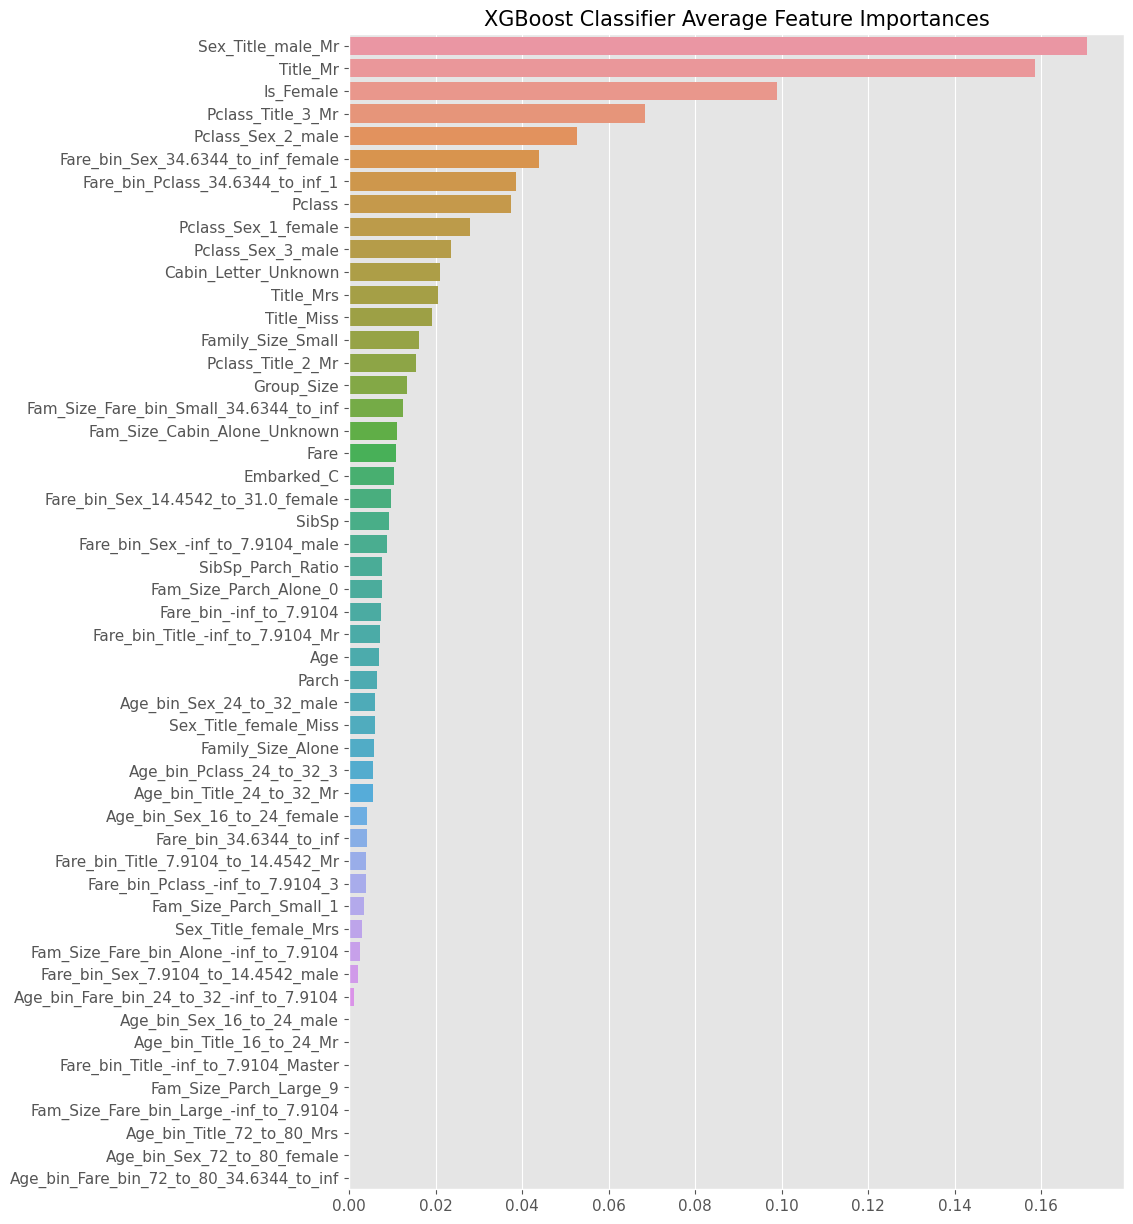

In [82]:
plt.figure(figsize=(10, int(len(feature_importances)/3.4)))
sns.barplot(x='Avg_Importance', y=feature_importances.index, data=feature_importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
plt.title('XGBoost Classifier Average Feature Importances', size=15)
plt.show()